*Machine Learning Assignment One -*

*Student Name: Zhenqi Zhang*

*Student ID: 20080833*

*Step One - Import Necessary Libraries and Load Data*

In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Import the Train and Test Data 
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

# Details about Train.CSV
print("Columns in Training Dataset:")
print(train_df.columns, "\n")
print(train_df.shape, "\n")

# Details about Test.CSV
print("\nColumns in Testing Dataset:")
print(test_df.columns, "\n")
print(test_df.shape, "\n")

train_df.dtypes

Columns in Training Dataset:
Index(['ID', 'Tank Failure Pressure (bar)', 'Liquid Ratio (%)',
       'Tank Width (m)', 'Tank Length (m)', 'Tank Height (m)',
       'BLEVE Height (m)', 'Vapour Height (m)', 'Vapour Temperature (K)',
       'Liquid Temperature (K)', 'Obstacle Distance to BLEVE (m)',
       'Obstacle Width (m)', 'Obstacle Height (m)', 'Obstacle Thickness (m)',
       'Obstacle Angle', 'Status', 'Liquid Critical Pressure (bar)',
       'Liquid Boiling Temperature (K)', 'Liquid Critical Temperature (K)',
       'Sensor ID', 'Sensor Position Side', 'Sensor Position x',
       'Sensor Position y', 'Sensor Position z', 'Target Pressure (bar)'],
      dtype='object') 

(10050, 25) 


Columns in Testing Dataset:
Index(['ID', 'Tank Failure Pressure (bar)', 'Liquid Ratio (%)',
       'Tank Width (m)', 'Tank Length (m)', 'Tank Height (m)',
       'BLEVE Height (m)', 'Vapour Height (m)', 'Vapour Temperature (K)',
       'Liquid Temperature (K)', 'Obstacle Distance to BLEVE (m)',
     

ID                                 float64
Tank Failure Pressure (bar)        float64
Liquid Ratio (%)                   float64
Tank Width (m)                     float64
Tank Length (m)                    float64
Tank Height (m)                    float64
BLEVE Height (m)                   float64
Vapour Height (m)                  float64
Vapour Temperature (K)             float64
Liquid Temperature (K)             float64
Obstacle Distance to BLEVE (m)     float64
Obstacle Width (m)                 float64
Obstacle Height (m)                float64
Obstacle Thickness (m)             float64
Obstacle Angle                     float64
Status                              object
Liquid Critical Pressure (bar)     float64
Liquid Boiling Temperature (K)     float64
Liquid Critical Temperature (K)    float64
Sensor ID                          float64
Sensor Position Side               float64
Sensor Position x                  float64
Sensor Position y                  float64
Sensor Posi

*Step Two - Preprocessing*

In [2]:
# 2 Preprocessing
#   2.1 Cleaning and Filling Missing Data
#       2.1.1 Remove Duplicate and Removing Unrelavant Columns to the Training
#       2.1.2 Remove Rows/Columns with too many Missing Values
#       2.1.3 Separating the Prediction Value from the Training Dataset
#       2.1.4 Feature Type Change (Status Feature)
#   2.2 Preprocessing Techniques
#       2.2.1 Plot to view the Outliers
#       2.2.2 Handle Missing Values using K Nearest Neighbour
#       2.2.3 Handle Skew Data
#       2.2.4 Handle Outliers
#       2.2.5 Plot to view the Outliers
#       2.2.6 Scaling the Data for Model Training
#   2.3 Split the Training Data into 80% Training and 20% Validation. And prepare the Test Data

In [3]:
# 2.1.1 Remove Duplicate and Removing Unrelavant Column

train_df = train_df.drop_duplicates(subset=['ID'])
test_df = test_df.drop_duplicates(subset=['ID'])

print(f"The Size of the Training Datafame is now {train_df.shape}")
print(f"The Size of the Testing Datafame is now {test_df.shape}\n")

train_df = train_df.drop('ID', axis=1)
test_df = test_df.drop('ID', axis=1)

# 2.1.2 Remove Rows/Columns with too many Missing Values - Count number of missing cases in each Row/Feautre. If the Row/Feature have too many missing cases, drop the Row/Feature. 

# There are only 24 features, and most of the rows are missing 20 features, 
# so I decide to just remove it since it would not be useful.
def remove_missing_data(df):

    # Store the rows that have one or more missing values
    missing_rows = df[df.isnull().sum(axis=1) > 0]
    
    # Check the Amount of Elements missing for each row
    missing_columns_value = missing_rows.isnull().sum(axis=1)

    for i in range(1, 25):
        count = np.sum(missing_columns_value == i)
        if count > 0:
            print(f"There are {count} rows with {i} missing values")   

    # Remove the rows with a number of missing values greater than the threshold. Missing 75%+ of the data
    df = df[df.isnull().sum(axis=1) < 18]
    print(f"The size of the DataFrame after removing rows with more than {18} missing values is now {df.shape}")
    
    return df

train_df = remove_missing_data(train_df)
test_df = remove_missing_data(test_df)

# 2.1.3 Splitting the Prediction Value from train.df 

y = train_df[['Target Pressure (bar)']]
train_df = train_df.drop(['Target Pressure (bar)'], axis=1)

# 2.1.4 Fix Specific Features - The 'Status' Features only have should be either Superheated or Subcooled, but it is either miss spell or Nan value. 

# Here, we will change the 'Status' to numerical values. Superheated related to number 0 and Subcooled related to number 1. Nan value would be left out for later on Fill in Missing Values.

def change_status(df):
    # Normalize the 'Status' column: lowercase and strip whitespace
    df['Status'] = df['Status'].str.lower().str.strip()
    
    # Map various statuses to numerical values
    status_map = {
        "superheated": 0, "superheat": 0, "saperheated": 0,  # Common misspellings for 'superheated'
        "subcooled": 1, "subcool": 1, "subcoled": 1           # Common misspellings for 'subcooled'
    }
    
    # Replace statuses according to the mapping
    df['Status'] = df['Status'].replace(status_map)

    return df

# Apply the function
train_df = change_status(train_df)
test_df = change_status(test_df)

The Size of the Training Datafame is now (9996, 25)
The Size of the Testing Datafame is now (3203, 24)

There are 100 rows with 1 missing values
There are 1 rows with 19 missing values
There are 5 rows with 20 missing values
The size of the DataFrame after removing rows with more than 18 missing values is now (9990, 24)
The size of the DataFrame after removing rows with more than 18 missing values is now (3203, 23)


C:\Users\Beii\AppData\Local\Temp\ipykernel_15104\3753128756.py:58: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Status'] = df['Status'].replace(status_map)


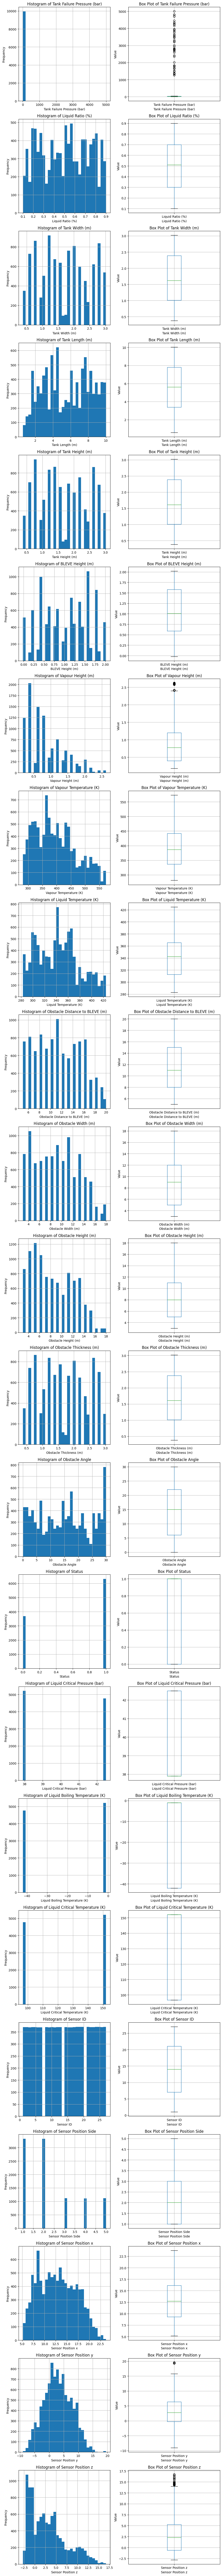

In [4]:
# 2.2.1 Plot to view the Outliers

features = train_df.columns

# Set up the matplotlib figure
fig, axes = plt.subplots(len(features), 2, figsize=(10, 5 * len(features)))  # Adjust the size as necessary

# Plot each feature
for i, feature in enumerate(features):
    # Histogram
    train_df[feature].hist(bins=30, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {feature}')
    axes[i, 0].set_xlabel(feature)
    axes[i, 0].set_ylabel('Frequency')

    # Boxplot
    train_df.boxplot(column=[feature], ax=axes[i, 1])
    axes[i, 1].set_title(f'Box Plot of {feature}')
    axes[i, 1].set_xlabel(feature)
    axes[i, 1].set_ylabel('Value')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

def preprocessing(train_df, test_df, numerical_cols):

    # 2.2.2 Handle Missing Values using K Nearest Neighbour
    imputer = KNNImputer(n_neighbors=5) 
    train_df[numerical_cols] = imputer.fit_transform(train_df[numerical_cols])
    test_df[numerical_cols] = imputer.transform(test_df[numerical_cols])

    # 2.2.3 Handle Skew Data
    yeo_johnson_transformer = PowerTransformer(method='yeo-johnson', standardize=False)
    train_df[numerical_cols] = yeo_johnson_transformer.fit_transform(train_df[numerical_cols])
    test_df[numerical_cols] = yeo_johnson_transformer.transform(test_df[numerical_cols])

    # 2.2.4 Handle Outliers
    robust_scaler = RobustScaler()
    train_df[numerical_cols] = robust_scaler.fit_transform(train_df[numerical_cols])
    test_df[numerical_cols] = robust_scaler.transform(test_df[numerical_cols])

    # 2.2.5 Scaling the Data for Model Training 
    minmax_scaler = MinMaxScaler(feature_range=(-1, 1))
    train_df[numerical_cols] = minmax_scaler.fit_transform(train_df[numerical_cols])
    test_df[numerical_cols] = minmax_scaler.transform(test_df[numerical_cols])

    return train_df, test_df

train_df, test_df = preprocessing(train_df, test_df, train_df.columns)

# 2.3

# Split the Training Data into 80% Training and 20% Validation
x_train, x_val, y_train, y_val = train_test_split(train_df, y, test_size=0.25, random_state=42) 

# Prediction for the Test Data will be x_test to better remember
x_test = test_df

*Model Development (SVR, MLP, LightGMB, RNN)*

In [5]:
# 3 Preprocessing
#   3.1 Removing some Unrelavant after evaluating the below modle training
#   3.2 SVR
#   3.3 MLP
#   3.4 LightGMB
#   3.5 RNN
#   3.6 Ensemble

In [6]:
# 3.1Removing These Features that are not closly related to the Prediction of the Models
x_train = x_train.drop(['Liquid Temperature (K)', 'Vapour Temperature (K)', 'Liquid Critical Temperature (K)', 'Liquid Boiling Temperature (K)'], axis=1)
x_val = x_val.drop(['Liquid Temperature (K)', 'Vapour Temperature (K)', 'Liquid Critical Temperature (K)', 'Liquid Boiling Temperature (K)'], axis=1)
x_test = x_test.drop(['Liquid Temperature (K)', 'Vapour Temperature (K)', 'Liquid Critical Temperature (K)', 'Liquid Boiling Temperature (K)'], axis=1)

Best Parameters: {'C': 10, 'epsilon': 0.01, 'gamma': 0.1}
Validation MAPE: 20.164480351589447%
Validation R^2: 0.83


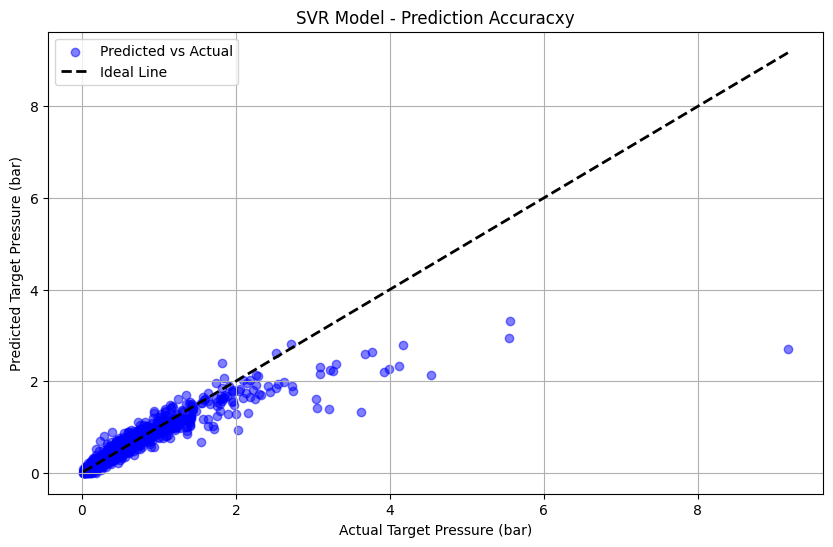

In [7]:
# 3.2 SVR Modle Training and Predicting

## Initial SVR Model Setup (Either use this or the Hyperparameter Tuning from Below. This one saves more time as it is the optimize parameter already.)
svr_model = SVR(kernel='rbf',
                C=10,
                epsilon=0.01,
                gamma=0.1)

# Hyperparameter Tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1],
    'epsilon': [0.01, 0.1, 0.2]
}

# GridSearch for the best model parameters
grid_search = GridSearchCV(svr_model, param_grid, cv=5, scoring='neg_mean_absolute_percentage_error')
grid_search.fit(x_train, y_train.values.ravel())

# Use the best Model
best_svr = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
# Best Parameter: C=10, epsilon=0.01, gamma=0.1

# svr_model.fit(x_train, y_train.values.ravel())

# Predict on validation and test sets. Prediction can not be less than 0
y_val_pred = best_svr.predict(x_val)
y_val_pred = np.maximum(y_val_pred, 0)
y_test_pred = best_svr.predict(x_test)
y_test_pred = np.maximum(y_test_pred, 0)

# Calculate MAPE
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
print(f"Validation MAPE: {val_mape * 100}%")

# Calculate R^2 
val_r2 = r2_score(y_val, y_val_pred)
print(f"Validation R^2: {val_r2:.2f}")

# Creating a DataFrame from the predictions
predictions_df = pd.DataFrame({
    "ID": range(0, len(y_test_pred)),
    "Predicted Target Pressure (bar)": y_test_pred
})

# Saving the DataFrame to an Excel file
predictions_df.to_csv("./Predictions/Predicted_Pressures_SVR.csv",float_format='%.9f', index=False)

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, color='blue', alpha=0.5, label='Predicted vs Actual')
plt.title('SVR Model - Prediction Accuracxy')
plt.xlabel('Actual Target Pressure (bar)')
plt.ylabel('Predicted Target Pressure (bar)')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2, label='Ideal Line')
plt.legend()
plt.grid(True)
plt.show()

# Validation MAPE: 20.909250341192298%

*MLP*

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01, 'solver': 'adam'}
Validation MAPE: 18.198397002266596%
Validation R^2: 0.95


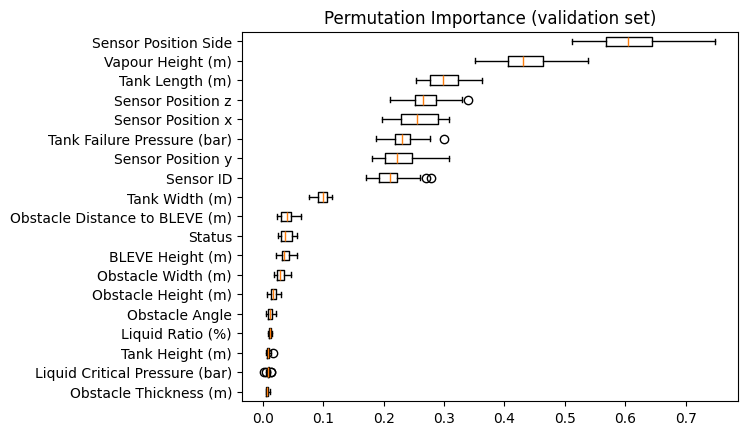

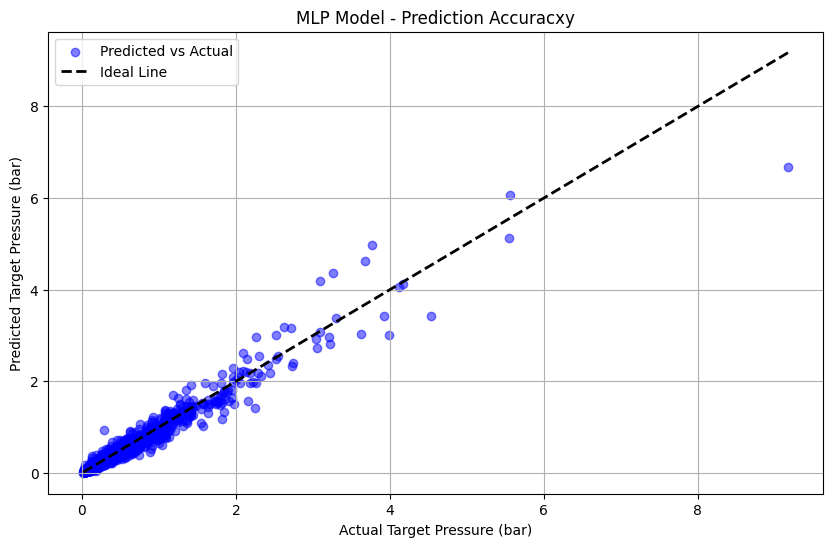

In [8]:
# 3.3 MLP Modle Training and Predicting

# Initial MLP Model Setup 
mlp = MLPRegressor(random_state=42, max_iter=500)

# Grid search for hyperparameters
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate_init': [0.001, 0.01]
}

grid_search = GridSearchCV(mlp, param_grid, cv=3, scoring='neg_mean_absolute_percentage_error', verbose=1)
grid_search.fit(x_train, y_train.values.ravel())
# Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01, 'solver': 'adam'}
# Validation MAPE: 18.198397002266596%
# Validation R^2: 0.95

# Best MLP model
best_mlp = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predictions and evaluation
y_val_pred = best_mlp.predict(x_val)

# Calculate MAPE
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
print(f"Validation MAPE: {val_mape * 100}%")

# Calculate R^2 
val_r2 = r2_score(y_val, y_val_pred)
print(f"Validation R^2: {val_r2:.2f}")

y_test_pred = best_mlp.predict(x_test)
y_test_pred = np.maximum(y_test_pred, 0)

# Creating a DataFrame from the predictions
predictions_df = pd.DataFrame({
    "ID": range(0, len(y_test_pred)),
    "Predicted Target Pressure (bar)": y_test_pred
})

# Saving the DataFrame to an Excel file
predictions_df.to_csv("./Predictions/Predicted_Pressures_MLP.csv",float_format='%.9f', index=False)

# Feature Importance 

# Calculate permutation importance

result = permutation_importance(best_mlp, x_val, y_val, n_repeats=30, random_state=42, n_jobs=-1)

# Plot the Result
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=x_val.columns[sorted_idx])
ax.set_title("Permutation Importance (validation set)")
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, color='blue', alpha=0.5, label='Predicted vs Actual')
plt.title('MLP Model - Prediction Accuracxy')
plt.xlabel('Actual Target Pressure (bar)')
plt.ylabel('Predicted Target Pressure (bar)')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2, label='Ideal Line')
plt.legend()
plt.grid(True)
plt.show()

*LightGBM*

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1707
[LightGBM] [Info] Number of data points in the train set: 4994, number of used features: 19
[LightGBM] [Info] Start training from score 0.357049
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found w

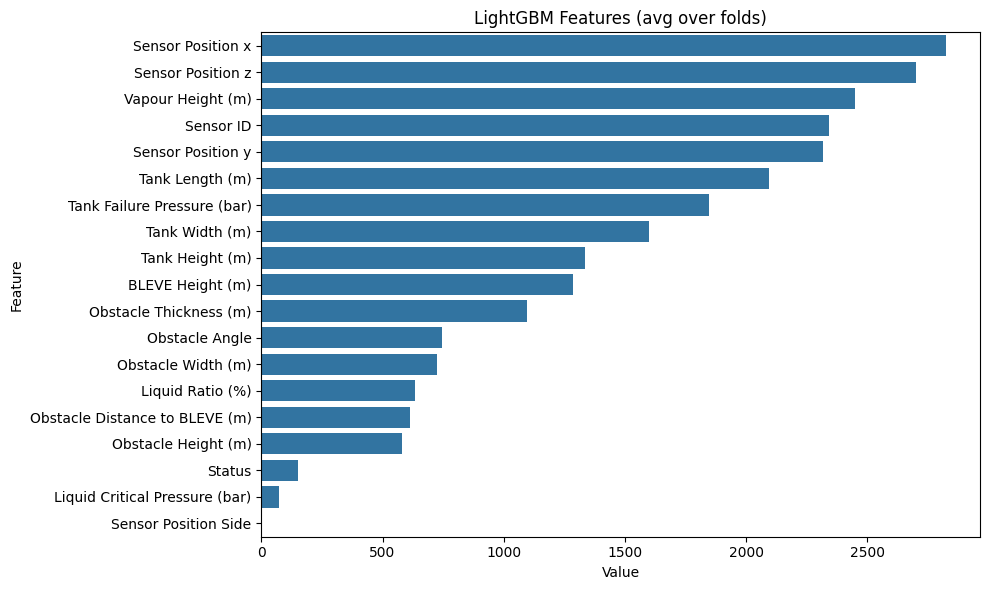

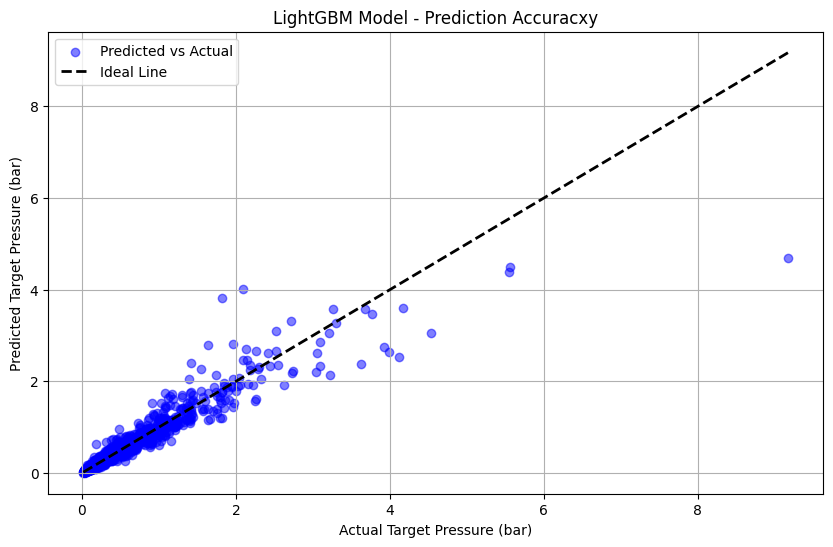

In [9]:
# 3.3 LightGBM Modle Training and Predicting

# Initial LightGBM Model Setup 
model = lgb.LGBMRegressor(random_state=42)

# Grid search for hyperparameters
param_grid = {
    'num_leaves': [31, 64, 128],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [20, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_percentage_error', verbose=1)
grid_search.fit(x_train, y_train)
# Best Parameters: {'learning_rate': 0.05, 'min_data_in_leaf': 20, 'n_estimators': 200, 'num_leaves': 128, 'reg_alpha': 0.1}

# Display best parameters and set Best MLP model
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Validate the model and Calculate MAPE
y_val_pred = best_model.predict(x_val)
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
print(f"Validation MAPE: {val_mape * 100:.2f}%")

# Calculate R^2 
val_r2 = r2_score(y_val, y_val_pred)
print(f"Validation R^2: {val_r2:.2f}")

# Test the model
y_test_pred = best_model.predict(x_test)
y_test_pred = np.maximum(y_test_pred, 0)

# Creating a DataFrame from the predictions
predictions_df = pd.DataFrame({
    "ID": range(0, len(y_test_pred)),
    "Predicted Target Pressure (bar)": y_test_pred
})

# Saving the DataFrame to an Excel file
predictions_df.to_csv("./Predictions/Predicted_Pressures_LightGBM.csv",float_format='%.9f', index=False)

# Best Parameters: {'learning_rate': 0.05, 'min_data_in_leaf': 20, 'n_estimators': 200, 'num_leaves': 128, 'reg_alpha': 0.1}
# Validation MAPE: 15.70%
# Validation R^2: 0.90

# Calculate and plot feature importance
feature_imp = pd.DataFrame(sorted(zip(best_model.feature_importances_, x_train.columns)), columns=['Value', 'Feature'])
plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, color='blue', alpha=0.5, label='Predicted vs Actual')
plt.title('LightGBM Model - Prediction Accuracxy')
plt.xlabel('Actual Target Pressure (bar)')
plt.ylabel('Predicted Target Pressure (bar)')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2, label='Ideal Line')
plt.legend()
plt.grid(True)
plt.show()

*RNN*

Best Hyperparameters: {'hidden_size': 100, 'num_layers': 3, 'lr': 0.001} with Validation MAPE: 14.68%, R2: 0.953


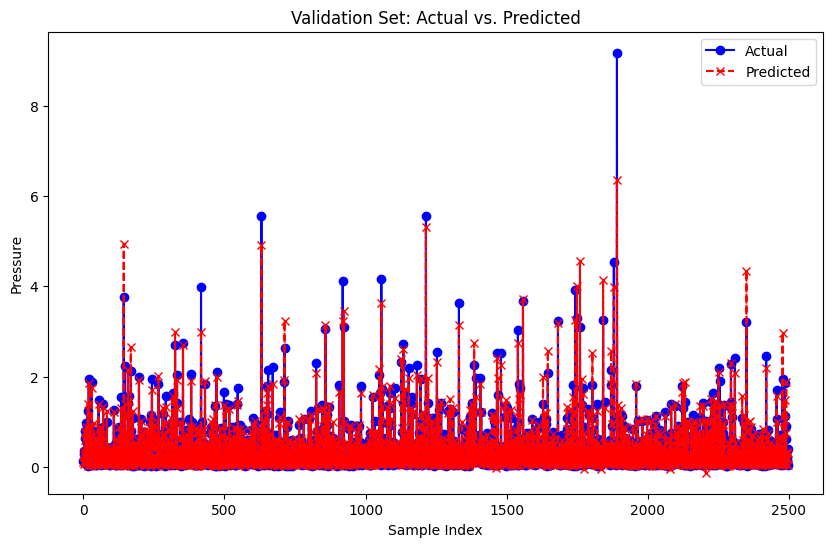

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Changing the Input Datas from Dataframe to Tensor
x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32).unsqueeze(1) 
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val.values, dtype=torch.float32).unsqueeze(1)  
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)  .unsqueeze(1)  

# DataLoader For the RNN. Ensurly each time the RNN trains, it is using different batch of datas
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor) 
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False) 
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  

# Define your RNN model class as before
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :]) 
        return out

# Define the MAPE loss function
def mape_loss(output, target):
    mask = target != 0
    return 100.0 * torch.mean(torch.abs((target[mask] - output[mask]) / target[mask]))

def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):

    best_val_mape = float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        for data, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            targets = targets.view_as(outputs)  
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        model.eval()
        val_mape = 0
        temp_actual = [] 
        temp_predicted = [] 
        with torch.no_grad():
            for data, targets in val_loader:
                outputs = model(data)
                targets = targets.view_as(outputs)
                mape = mape_loss(outputs, targets)
                val_mape += mape.item()

        val_mape /= len(val_loader)
        if val_mape < best_val_mape:
            best_val_mape = val_mape
            best_model_state = model.state_dict()

    model.load_state_dict(best_model_state)

    return model

# Hyperparameters sets
hidden_sizes = [50, 100, 150]
num_layers = [1, 2, 3]
learning_rates = [0.001, 0.01, 0.1]

best_hyperparams = None
best_val_mape = float('inf')
best_val_r2 = float('inf')
best_model = None

for hidden_size in hidden_sizes:
    for num_layer in num_layers:
        for lr in learning_rates:
            model = RNNModel(input_size=x_train.shape[1], hidden_size=hidden_size, num_layers=num_layer, output_size=1)
            optimizer = optim.Adam(model.parameters(), lr=lr)
            criterion = nn.MSELoss()

            model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=400)
            # Evaluate the model to find the best one
            model.eval()
            val_mape = 0
            val_r2 = 0
            with torch.no_grad():
                for data, targets in val_loader:
                    outputs = model(data)
                    targets = targets.view_as(outputs)
                    val_mape += mape_loss(outputs, targets).item()
                    val_r2 += r2_loss(outputs, targets).item()

            val_mape /= len(val_loader)
            val_r2 /= len(val_loader)
            if val_mape < best_val_mape:
                best_val_mape = val_mape
                best_val_r2 = val_r2
                best_hyperparams = {'hidden_size': hidden_size, 'num_layers': num_layer, 'lr': lr}
                best_model = model

print(f"Best Hyperparameters: {best_hyperparams} with Validation MAPE: {best_val_mape:.2f}%, R2: {best_val_r2:.3f}")

# Predict the Test set
def predict(model, test_loader):
    model.eval()  
    predictions = []
    with torch.no_grad():
        for data in test_loader:
            outputs = model(data[0])  
            predictions.extend(outputs.cpu().numpy())  

    return np.array(predictions).flatten() 

# Execute the prediction function
y_test_pred = predict(best_model, test_loader)
y_test_pred = np.maximum(y_test_pred, 0) 
test_ids = np.arange(len(y_test_pred)) 

# Create a DataFrame to store the results
predictions_df = pd.DataFrame({
    "ID": test_ids,
    "Predicted Target Pressure (bar)": y_test_pred
})

# Save the DataFrame to a CSV file
predictions_df.to_csv("./Predictions/Predicted_Pressures_RNN.csv", float_format='%.9f', index=False)

# Best Hyperparameters: {'hidden_size': 150, 'num_layers': 3, 'lr': 0.001} with Validation MAPE: 16.67%

def plot_predictions(model, loader, title="Actual vs. Predicted"):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for data, targets in loader:
            outputs = model(data)
            predictions.extend(outputs.view(-1).cpu().numpy())
            actuals.extend(targets.view(-1).cpu().numpy())

    plt.figure(figsize=(10, 6))
    plt.plot(actuals, label='Actual', color='blue', marker='o')
    plt.plot(predictions, label='Predicted', color='red', linestyle='--', marker='x')
    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Pressure')
    plt.legend()
    plt.show()

# Plot actual vs. predicted values on the validation set
plot_predictions(best_model, val_loader, title="Validation Set: Actual vs. Predicted")


In [11]:
# 3.5 Emsemble the Models Together (Not the SVR since it is not performing that well.)

LightGBM_data = pd.read_csv('./Predictions/Predicted_Pressures_LightGBM.csv')
LightGBM_data = LightGBM_data["Predicted Target Pressure (bar)"]

MLP_data = pd.read_csv('./Predictions/Predicted_Pressures_MLP.csv')
MLP_data = MLP_data["Predicted Target Pressure (bar)"]

MLP_data = pd.read_csv('./Predictions/Predicted_Pressures_MLP.csv')
MLP_data = MLP_data["Predicted Target Pressure (bar)"]

RNN_data = pd.read_csv('./Predictions/Predicted_Pressures_RNN.csv')
RNN_data = RNN_data["Predicted Target Pressure (bar)"]

predictions_df = pd.DataFrame({
    "ID": range(0, len(y_test_pred)),
    "Predicted Target Pressure (bar)": (LightGBM_data+MLP_data+RNN_data)/3
})

# Saving the DataFrame to an Excel file
predictions_df.to_csv("./Prediction.csv",float_format='%.9f', index=False)